In [4]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.6 MB/s eta 0:00:00


In [48]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('/content/drive/MyDrive/textgenerationData/QuaideAzam.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 104576


In [49]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

phrases are used such as Purna Swaraj, selfgovernment, complete independence, responsible government, substance of independence, and dominion status. There are some who talk of complete independence. B


In [50]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [51]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [52]:
def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    # print(inp.shape)
    # print(target.shape)
    return inp, target

In [53]:
random_training_set()

(tensor([94, 29, 24, 94, 12, 24, 22, 14, 94, 29, 24, 94, 29, 17, 10, 29, 94, 36,
         28, 28, 14, 22, 11, 21, 34, 73, 94, 10, 23, 13, 94, 29, 17, 14, 23, 94,
         28, 10, 34, 28, 94, 74, 74, 94, 63, 13, 14, 12, 21, 10, 27, 14, 94, 29,
         17, 10, 29, 94, 29, 17, 14, 27, 14, 94, 18, 28, 94, 23, 24, 29, 17, 18,
         23, 16, 94, 12, 24, 22, 22, 24, 23, 94, 11, 14, 29, 32, 14, 14, 23, 94,
         43, 18, 23, 13, 30, 28, 94, 10, 23, 13, 94, 48, 30, 28, 21, 18, 22, 28,
         73, 94, 29, 17, 14, 23, 94, 10, 21, 24, 23, 14, 94, 44, 94, 32, 24, 30,
         21, 13, 94, 16, 18, 31, 14, 94, 30, 25, 94, 10, 21, 21, 94, 17, 24, 25,
         14, 73, 94, 11, 30, 29, 94, 14, 31, 14, 23, 94, 29, 17, 14, 23, 94, 44,
         94, 32, 24, 30, 21, 13, 94, 10, 16, 27, 14, 14, 94, 32, 18, 29, 17, 94,
         29, 17, 14, 22, 94, 11, 14, 12, 10, 30, 28, 14, 94, 29, 17, 14, 34, 94,
         27, 14]),
 tensor([29, 24, 94, 12, 24, 22, 14, 94, 29, 24, 94, 29, 17, 10, 29, 94, 36, 28,
         

In [54]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [55]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [56]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / (chunk_len - 1)

In [57]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch/n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 16s (100 5%) 2.0801]
Wh. Breteag. teand was belea yo wes, wave worh ant age sablerat of aw emesande cetheekeard you sons we 

 33s (200 10%) 2.0520]
Where whatill allive sectia wirns ardiong and inr that can the conrpill and the Muh you the fores. Tha 

 50s (300 15%) 1.8539]
Wh butory hing whas [ing the tikighent take in.] Lakers whus the as pre of are pority and pay the cons 

 6s (400 20%) 1.8135]
Wh be your youghen I whish leards, Erot this the his leffellfered in agurenertan, they a le with the s 

 22s (500 25%) 1.6227]
Whish mal I ciered the Muslim Leighter instay ownh and sure the mainrity the man restore effere and to 

 38s (600 30%) 1.5762]
Whques and propprorgan as unition, the provincect and the sice the now ember concearition the Muslims  

 55s (700 35%) 1.9661]
Whish ment consistande our recially vere scho sup our and connestitution and and shour considere, oner 

 11s (800 40%) 1.6965]
Whis's are deveral of I shed the the Muslim League aindish what is is a dearsed I d

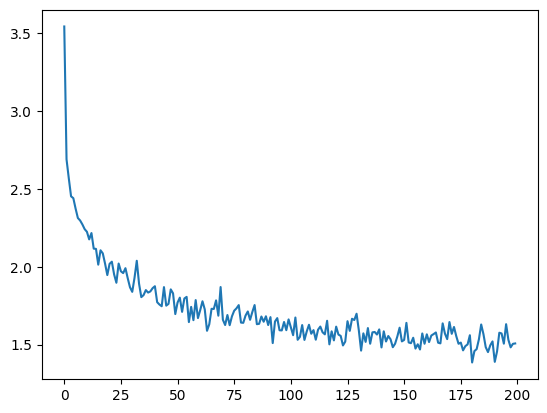

In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [59]:
print(evaluate('Th', 200, temperature=0.8))

These Pajends of this a devised of the forge the lave the said. You when that be relemblents im that the Musalman in dever the grise. The can repecisually be the sing to have great do no stated to domin


In [60]:
print(evaluate('Th', 200, temperature=0.2))

The said the Congress the Muslim League of the of the Congress that the last the fore the Congress that the light the last the Muslim League. The realise that the last the Congress and demority of the C


In [61]:
print(evaluate('Th', 200, temperature=1.4))

That natiogal way of Primations, we prestate goals', Indus whothe. Gao{ stupt ah thore live difffureg. Catckemticome. Every up prepiragamin?
One of power. Mad.
Ongse har. 'f I smilnd [e thist, that mini
